In [1]:
import osmnx as ox
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
from contextily import Place
import folium
from shapely.geometry import Polygon
import ast
import pandas as pd
from shapely.geometry import Point, LineString
from networkx.readwrite import json_graph
import numpy as np
import random
from numpy.random import choice
import seaborn as sns
from branca.colormap import LinearColormap,StepColormap
import plotly.express as px
from branca.colormap import linear
from pyproj import Transformer, transform
import pyproj
from GAclass import GeneticAlgorithm
from GAMOclass import GAMO
import pickle
import os
from GenerateSubgraphClass import get_subgraph,cartesian_to_geographical,geographical_to_cartesian,get_points_inside_circle2
from datasets_creation import load_my_graph

ox.settings.log_console=True
ox.settings.use_cache=True

In [32]:
from base64 import b64encode

In [ ]:
## (45.651315, 25.6160439) (45.6597107, 25.6069272) RUTA INTERESANTA

In [19]:
%load_ext autoreload
%autoreload 2
#%reload_ext autoreload

In [20]:
from GAclass import GeneticAlgorithm
from GAMOclass import GAMO
from datasets_creation import load_my_graph


In [2]:
%%time
G, G_projected= load_my_graph()
# Convert graphs to GeoDataFrames
nodes, edges = ox.graph_to_gdfs(G)
nodes_cartesian, edge_cartesian = ox.graph_to_gdfs(G_projected)
print(len(G.nodes))

3282
Wall time: 1.04 s


In [3]:
successors_dict = {node: list(G.successors(node)) for node in G.nodes()}

In [5]:
# Specify the filename
filename = "successors_dictionary.pkl"

# Save the dictionary to a file
with open(filename, 'wb') as f:
    pickle.dump(successors_dict, f)

print("Successors dictionary saved to", filename)

Successors dictionary saved to successors_dictionary.pkl


In [7]:
# Specify the filename
filename = "successors_dictionary.pkl"

# Load the dictionary from the file
with open(filename, 'rb') as f:
    successors_dict = pickle.load(f)

print("Successors dictionary loaded from", filename)
# Now you can use successors_dict

Successors dictionary loaded from successors_dictionary.pkl


In [37]:
%%time
while True:
    try:
        data = get_subgraph()
        origin = data['origin']
        destination = data['destination']
        origin_geograph = data['origin_geogr']
        destination_geograph = data['destination_geogr']
        radius = data['radius']
        center_point= data['center_point']
        route_gdf = data['route_gdf']
        route = data['route']
        successors_dict = data['successors_dict']
        subset_of_nodes = data['subset_of_nodes']
        nodes_geographical = data['nodes_geographical']
        route_gdf_geographical = data['route_gdf_geographical']
        center_point_geographical = data['center_point_geographical']
        subgraph = nx.subgraph(G, subset_of_nodes.index)
        if 900< route_gdf['length'].sum() < 3500:
            break
    except Exception as e:
        print("An error occurred:", e)
        continue
print(route_gdf['length'].sum())
print(origin_geograph, destination_geograph)

2783.513
(45.6676921, 25.5840364) (45.6707077, 25.6112029)
Wall time: 1.26 s


In [39]:
destination

2046127341

In [4]:
dij = ox.shortest_path(G, origin, destination, weight='length') # type: ignore
#neaparat G_projected, lucrez in sist cartezian!!
route_gdf = ox.routing.route_to_gdf(G_projected, dij) # type: ignore
# Calculate route length
route_length = route_gdf['length'].sum()
# Calculate the bounding box of the route
minx, miny, maxx, maxy = route_gdf.total_bounds
radius = max(ox.distance.euclidean(miny, minx, maxy, maxx) / 2, route_length / 2)
# Define the projection systems
source_crs = 'epsg:32635' # Coordinate system of the file
target_crs = 'epsg:4326' # Global lat-lon coordinate system
nodes, edges = ox.graph_to_gdfs(G)
nodes_cartesian, edge_cartesian = ox.graph_to_gdfs(G_projected) # type: ignore
center_point = ((maxy + miny) / 2, (maxx + minx) / 2)
center_point_cartesian = Point(center_point[1], center_point[0])
inside_nodes = get_points_inside_circle2(nodes_cartesian, radius, center_point_cartesian)
subset_of_nodes = nodes[nodes.index.isin(inside_nodes.index)]
subgraph_dij= G.subgraph(list(subset_of_nodes.index)) # type: ignore

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

In [ ]:
pushpin = folium.features.CustomIcon('/content/drive/My Drive/Colab Notebooks/pushpin.png', icon_size=(30,30))


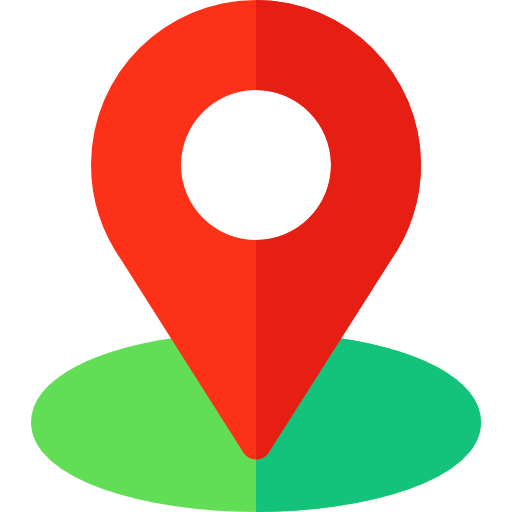
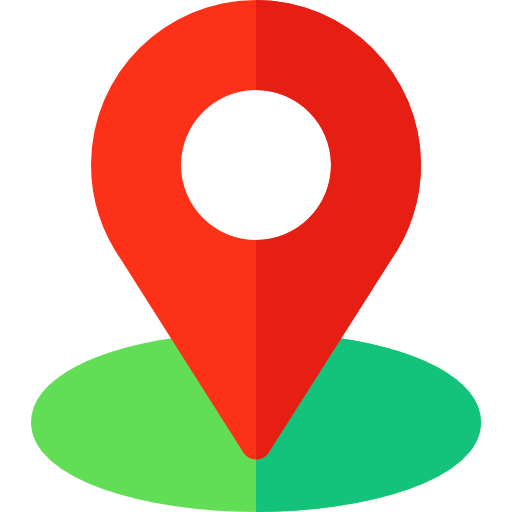

In [36]:
# Read the image file and encode it to base64
with open("C:/Users/Camelia/Desktop/location_button.png", "rb") as image_file:
    encoded_image = b64encode(image_file.read()).decode()

# Create the HTML string for the custom icon using base64 encoding
custom_icon_html = f"""
<div style="background-color:transparent;">
    <img src="data:image/png;base64,{encoded_image}" style="width:38x;height:95px;">
</div>
"""


# Convert route_gdf to geographical coordinates system
route_gdf_geographical = route_gdf.to_crs(epsg=4326)

# Define the center of the map
map_center = (subgraph_dij.nodes[list(subgraph_dij.nodes())[0]]['y'], subgraph_dij.nodes[list(subgraph_dij.nodes())[0]]['x'])

# Create a Folium map
mymap = folium.Map(location=map_center, zoom_start=12)

# Define start and end coordinates
start_coords = (route_gdf_geographical['geometry'].iloc[0].coords[0][1], route_gdf_geographical['geometry'].iloc[0].coords[0][0])
end_coords = (route_gdf_geographical['geometry'].iloc[-1].coords[-1][1], route_gdf_geographical['geometry'].iloc[-1].coords[-1][0])

folium.Marker(
    location=start_coords,
    popup=f"<strong>Start:</strong> {start_coords}",
    tooltip="Start Location",
    icon=folium.DivIcon(html=custom_icon_html)
).add_to(mymap)

folium.Marker(
    location=end_coords,
    popup=f"<strong>Start:</strong> {end_coords}",
    tooltip="Start Location",
    icon=folium.DivIcon(html=custom_icon_html)
).add_to(mymap)
# Add the route line to the map
folium.PolyLine(
    locations=[(point.xy[1][0], point.xy[0][0]) for point in route_gdf_geographical['geometry'].apply(lambda x: x.coords)],
    color='blue',
    weight=5,
    opacity=0.7
).add_to(mymap)
mymap

In [25]:
# Create a Folium map centered around the place
route_gdf_geographical = route_gdf.to_crs(epsg=4326)

map_center = (subgraph_dij.nodes[list(subgraph_dij.nodes())[0]]['y'], subgraph_dij.nodes[list(subgraph_dij.nodes())[0]]['x'])
mymap = folium.Map(location=map_center, zoom_start=12)

start_coords = (route_gdf_geographical['geometry'].iloc[0].coords[0][1], route_gdf_geographical['geometry'].iloc[0].coords[0][0])
end_coords = (route_gdf_geographical['geometry'].iloc[-1].coords[-1][1],route_gdf_geographical['geometry'].iloc[-1].coords[-1][0])
    #folium.Marker(location=[coords[0][0], coords[0][1]]).add_to(mymap)
# Add a marker for the start location with a custom icon
folium.Marker(
    location=start_coords,
    popup=f"<strong>Start:</strong> {start_coords}",
    tooltip="Start Location",
    icon=folium.Icon(color='green', icon_image=icon_image_path, icon_size=(38, 95))
).add_to(mymap)


folium.Marker(
                location=end_coords,
                popup=f"<strong>End:</strong> {end_coords}",
                tooltip="End Location",
                icon=folium.Icon(color='red', icon='stop')
            ).add_to(mymap)
for geom in route_gdf_geographical['geometry']:
     #coords = [(coord[1], coord[0]) for coord in geom.coords]  # Use (latitude, longitude) order
    #folium.PolyLine(locations=coords, color='blue').add_to(mymap)
    coords = [(coord[1], coord[0]) for coord in geom.coords]  # Use (latitude, longitude) order
    folium.PolyLine(
                    locations=coords, 
                    color='#2b8100', 
                    weight=5, 
                    opacity=0.8, 
                    tooltip="Route"
                ).add_to(mymap)
    
mymap    

In [8]:
%%time
ga = GeneticAlgorithm(G, successors_dict, source=origin, destination=destination)
gd = GAMO(G, successors_dict, origin, destination,popsize=2)

Wall time: 6.54 ms


In [10]:
best, fitnessOfBest = gd.run(ngen=1,logs_path="")

I did nbot send another api...
I did nbot send another api...
I did nbot send another api...
Best chromosome in generation nr. 1 is: [262799397, 293743179, 293743184, 293743175, 293742899, 293742898, 293742877, 293742943, 6397716730, 2340332499, 2340332524] and its fitness is: (0, 952, 112)


In [34]:
route_GA =best[0]

In [149]:
for i in range(len(route_GA) - 1):
        if not G.has_edge(route_GA[i], route_GA[i+1]):
            # If there is no edge between consecutive nodes, raise an exception
            print(f"Edge missing between nodes:{route_GA[i]} and {route_GA[i+1]}")
        else:
              print(f"Edge present between node {route_GA[i]} and node {route_GA[i+1]}")

Edge present between node 6481207004 and node 6481206991
Edge present between node 6481206991 and node 2776837893
Edge present between node 2776837893 and node 2776837891
Edge present between node 2776837891 and node 6481207003
Edge present between node 6481207003 and node 6481206988
Edge present between node 6481206988 and node 2001693005
Edge present between node 2001693005 and node 2265531477
Edge present between node 2265531477 and node 3439287650
Edge present between node 3439287650 and node 2328345804
Edge present between node 2328345804 and node 6481767070
Edge present between node 6481767070 and node 6481767068
Edge present between node 6481767068 and node 6481767075
Edge present between node 6481767075 and node 6481767287
Edge present between node 6481767287 and node 6481767286
Edge present between node 6481767286 and node 262798004
Edge present between node 262798004 and node 2622105837
Edge present between node 2622105837 and node 1995865717


In [16]:
dij = ox.shortest_path(G, origin, destination, weight='length')
#route_GA = best[0]

# Get the actual route as a GeoDataFrame of edges
route_gdf = ox.routing.route_to_gdf(G_projected, dij) #neaparat G_projected, lucrez in sist cartezian!!
# Calculate route length
route_length = route_gdf['length'].sum()
# Calculate the bounding box of the route
minx, miny, maxx, maxy = route_gdf.total_bounds
radius = max(ox.distance.euclidean(miny, minx, maxy, maxx) / 2, route_length / 2)
# Define the projection systems
source_crs = 'epsg:32635' # Coordinate system of the file
target_crs = 'epsg:4326' # Global lat-lon coordinate system
nodes, edges = ox.graph_to_gdfs(G)
nodes_cartesian, edge_cartesian = ox.graph_to_gdfs(G_projected)
center_point = ((maxy + miny) / 2, (maxx + minx) / 2)
center_point_cartesian = Point(center_point[1], center_point[0])
inside_nodes = get_points_inside_circle2(nodes_cartesian, radius, center_point_cartesian)
subset_of_nodes = nodes[nodes.index.isin(inside_nodes.index)]
subgraph_dij= G.subgraph(list(subset_of_nodes.index))

In [112]:
sum(ox.utils_graph.get_route_edge_attributes(G, dij, attribute="length"))

C:\Users\Camelia\AppData\Local\Temp/ipykernel_18604/3206122341.py:1: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  sum(ox.utils_graph.get_route_edge_attributes(G, dij, attribute="length"))


693.816

                                red: Genetic Algorithm result, yellow: Djikstra


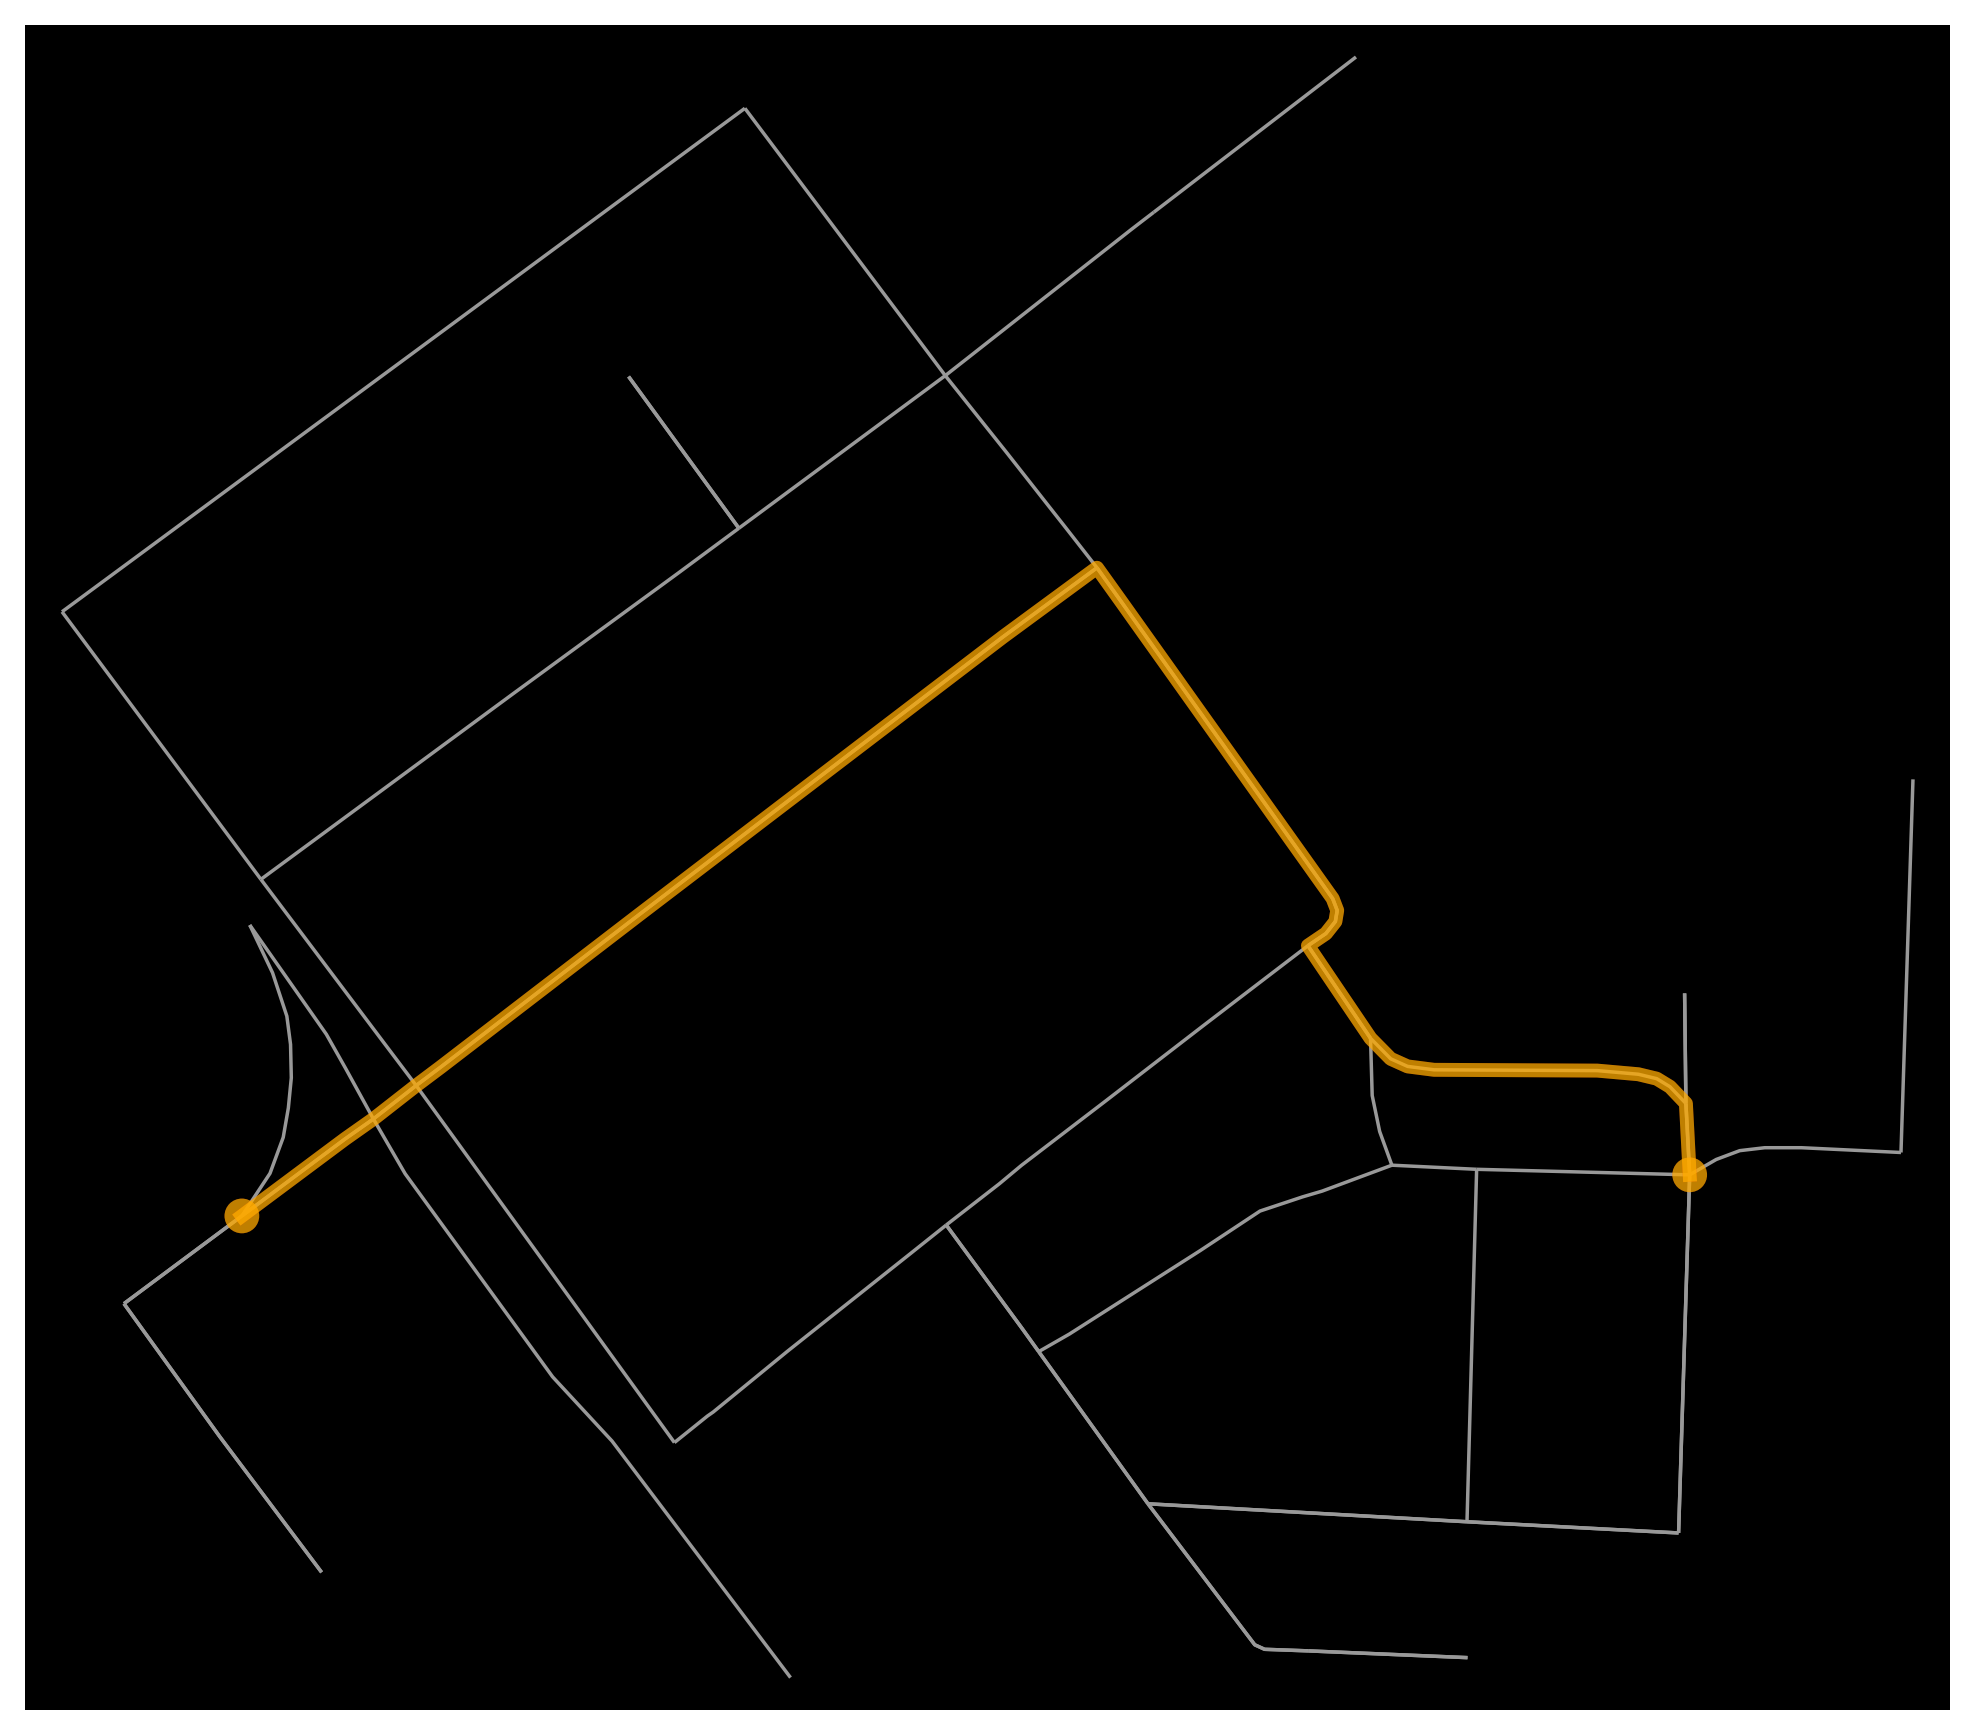

In [170]:
rc = ['red','yellow']
routes =[route_GA, dij]

plt.rcParams["figure.dpi"] = 250
plt.rcParams["figure.autolayout"] = True
print(f"                                {rc[0]}: Genetic Algorithm result, {rc[1]}: Djikstra")

fig, ax = ox.plot_graph_routes(subgraph_dij, routes, route_colors=rc, route_linewidth=1, node_size=0,bgcolor ='black')
ax.set_title(f"{rc[0]}: Genetic Algorithm result, {rc[1]}: Djikstra")
plt.show()

In [29]:
# Create a Folium map centered around the place
route_gdf_GA = ox.routing.route_to_gdf(G_projected, route_GA) #neaparat G_projected, lucrez in sist cartezian!!
route_gdf_geographical_GA = route_gdf_GA.to_crs(epsg=4326)
map_center = (subgraph_dij.nodes[list(subgraph_dij.nodes())[0]]['y'], subgraph_dij.nodes[list(subgraph_dij.nodes())[0]]['x'])
mymap = folium.Map(location=map_center, zoom_start=12)
for geom in route_gdf_geographical_GA['geometry']:
    coords = [(coord[1], coord[0]) for coord in geom.coords]  # Use (latitude, longitude) order
    folium.PolyLine(locations=coords, color='blue').add_to(mymap)
    folium.Marker(location=[coords[0][0], coords[0][1]]).add_to(mymap)

In [30]:
mymap

In [121]:
# Create a Folium map centered around the place
route_gdf_geographical = route_gdf.to_crs(epsg=4326)

map_center = (subgraph_dij.nodes[list(subgraph_dij.nodes())[0]]['y'], subgraph_dij.nodes[list(subgraph_dij.nodes())[0]]['x'])
mymap = folium.Map(location=map_center, zoom_start=12)
for geom in route_gdf_geographical['geometry']:
    coords = [(coord[1], coord[0]) for coord in geom.coords]  # Use (latitude, longitude) order
    folium.PolyLine(locations=coords, color='blue').add_to(mymap)
    folium.Marker(location=[coords[0][0], coords[0][1]]).add_to(mymap)

#folium.CircleMarker(location=[45.6312675, 25.6374638], radius=5, color='green', fill=True, fill_color='magenta').add_to(mymap)
#folium.CircleMarker(location=[45.6194117, 25.6372102], radius=5, color='green', fill=True, fill_color='magenta').add_to(mymap)
    

In [122]:
mymap

In [31]:
mymap.save("Route_goodExample.html")

In [ ]:
graph_file_geographical = "graph_geographical_coords.pkl"
graph_file_cartesian = "graph_cartesian_coords.pkl"

# Save the geographical graph
with open(graph_file_geographical, "wb") as f:
    pickle.dump(G, f)

# Save the projected graph
with open(graph_file_cartesian, "wb") as f:
    pickle.dump(G_projected, f)

In [ ]:
'''
def get_points_inside_circle(nodes_geographical, radius, center_point):
    inside_circle_nodes = []
    indexs = []
    # Convert node coordinates to Cartesian for distance calculation
    for index, node in nodes_geographical.iterrows():
        node_x = node['geometry'].x
        node_y = node['geometry'].y
        node_cartesian = Point(geographical_to_cartesian(node_y, node_x))

        # Check if the point falls within the circle
        if center_point.distance(node_cartesian) <= radius:
                inside_circle_nodes.append(Point(node_y, node_x))
                indexs.append(index)
            
    # Convert the nodes into geographical coords
    # Create a GeoDataFrame from the points inside the circle
    inside_circle_gdf = gpd.GeoDataFrame(geometry=inside_circle_nodes, crs=nodes_geographical.crs)
    
    # Convert the coordinates of the GeoDataFrame to EPSG:4326
    #inside_circle_gdf = inside_circle_gdf.to_crs(epsg=4326)
  
    # Set index column to indexx
    inside_circle_gdf.index = indexs
    
    return inside_circle_gdf
'''

In [ ]:
'''
# Create a Folium map centered at the center of the route
m = folium.Map(location=[center_point_geographical.x, center_point_geographical.y], zoom_start=12)

# Add the route to the map
for geom in route_gdf_geographical['geometry']:
    coords = [(coord[1], coord[0]) for coord in geom.coords]  # Use (latitude, longitude) order
    folium.PolyLine(locations=coords, color='blue').add_to(m)

# Iterate over all nodes in the nodes GeoDataFrame and add nodes inside the circle to the map
for index, node in nodes_geographical.iterrows():
    node_x = node['geometry'].x
    node_y = node['geometry'].y
    
    # Convert node coordinates to Cartesian for distance calculation

    node_cartesian = Point(geographical_to_cartesian(node_y, node_x))
    
    # Check if the point falls within the circle
    if center_point_cartesian.distance(node_cartesian) <= radius:
        folium.CircleMarker(location=[node_y, node_x], radius=5, color='green', fill=True, fill_color='magenta').add_to(m)
        indx.append((node_y, node_x))

# Create a circle
circle = folium.Circle(location=[center_point_geographical.x, center_point_geographical.y], radius=radius, color='yellow', fill=True, fill_opacity=0.2)
circle.add_to(m)

# Display the map
m
'''

In [ ]:
# Create a Folium map centered at the center of the route
m = folium.Map(location=[center_point_geographical.x, center_point_geographical.y], zoom_start=12)

# Add the route to the map
for geom in route_gdf_geographical['geometry']:
    coords = [(coord[1], coord[0]) for coord in geom.coords]  # Use (latitude, longitude) order
    folium.PolyLine(locations=coords, color='blue').add_to(m)

for geom in subset_of_nodes['geometry']:
    node_x = geom.x
    node_y = geom.y 
    folium.CircleMarker(location=[node_y, node_x], radius=5, color='green', fill=True, fill_color='magenta').add_to(m)


# Create a circle
circle = folium.Circle(location=[center_point_geographical.x, center_point_geographical.y], radius=radius, color='yellow', fill=True, fill_opacity=0.2)
circle.add_to(m)

# Display the map
m